In [ ]:
import torch

device = torch.device('cuda')
# device = 'cpu'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip /content/drive/MyDrive/SpeechDiffusion/speechcoco-data.zip

Streaming output truncated to the last 5000 lines.
  inflating: data/wavs/1204996216_71d7519d9a_0.wav  
  inflating: data/wavs/3661659196_6ed90f96c0_1.wav  
  inflating: data/wavs/2959581023_54402c8d88_0.wav  
  inflating: data/wavs/2535746605_8124bf4e4f_2.wav  
  inflating: data/wavs/3621717946_d96f8a6012_3.wav  
  inflating: data/wavs/195084264_72fb347b0f_1.wav  
  inflating: data/wavs/2081615901_13092cac56_0.wav  
  inflating: data/wavs/2623247254_3bfc795121_1.wav  
  inflating: data/wavs/1402843760_d30f1dbf0f_3.wav  
  inflating: data/wavs/3364715316_df8c20bac1_4.wav  
  inflating: data/wavs/782401952_5bc5d3413a_4.wav  
  inflating: data/wavs/185972340_781d60ccfd_0.wav  
  inflating: data/wavs/3351586010_7ffaa90ea8_1.wav  
  inflating: data/wavs/544301311_5e7d69a517_4.wav  
  inflating: data/wavs/2924259848_effb4dcb82_4.wav  
  inflating: data/wavs/3339105374_cc41e0b7d7_2.wav  
  inflating: data/wavs/2555535057_007501dae5_2.wav  
  inflating: data/wavs/269986132_91b71e8aaa_0.wav  


In [ ]:
with open('/content/drive/MyDrive/SpeechDiffusion/samples500.txt', 'r') as file:
  samples_500 = [line.strip() for line in file.readlines()]

In [ ]:
import pandas as pd

wav2cap = pd.read_csv('data/wav2capt.txt', sep = ' ', header=None)
wav2cap = wav2cap.sample(frac=1)

wav2cap_dict = dict(zip(wav2cap[0], wav2cap[1]))

# subset1k = wav2cap[wav2cap[1].isin(list(set(wav2cap[1]))[:10])]
# wav2cap_subset1k_dict = dict(zip(subset1k[0], subset1k[1]))

# subset500 = wav2cap[wav2cap[1].isin(samples_500)]
# wav2cap_subset500_dict = dict(zip(subset500[0], subset500[1]))

import os
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import soundfile as sf

from torchvision import transforms
from transformers import AutoProcessor, HubertModel
from torch.nn.utils.rnn import pad_sequence

processor = AutoProcessor.from_pretrained("facebook/hubert-large-ls960-ft")

# Get the number of available processors
num_processors = os.cpu_count()

batch_size = 64*2

def collate_batch(batch):
    images, audio_sequences = zip(*batch)
    images = torch.stack(images, 0)

    # Pad the audio sequences to have the same length
    audio_sequences = pad_sequence(audio_sequences, batch_first=True)

    return images, audio_sequences

# Example dataset class
class ImageTextDataset(Dataset):
    def __init__(self, wav2cap_dict, speech_processor, image_size=224, data_path='data'):
        self.caption_filenames = list(wav2cap_dict.keys())
        self.transform = transforms.Compose([
                    transforms.Resize((image_size, image_size)),
                    transforms.ToTensor()])

        self.wav2cap_dict = wav2cap_dict
        self.data_path = data_path
        self.speech_processor = speech_processor

    def __len__(self):
        return len(self.caption_filenames)

    def __getitem__(self, index):

        item = self.caption_filenames[index]

        # IMAGE
        image = Image.open(os.path.join(self.data_path, 'images', self.wav2cap_dict.get(item)))
        image = self.transform(image)

        # SPEECH
        raw_speech, sampling_rate = sf.read(os.path.join(self.data_path, 'wavs', item))
        speech_output = self.speech_processor(raw_speech, return_tensors="pt", sampling_rate=sampling_rate).input_values.squeeze(0)
        # print(speech_output[0].shape)
        # return image, raw_speech

        return image, speech_output

# dataset = ImageTextDataset(wav2cap_dict, processor)
dataset = ImageTextDataset(wav2cap_dict, processor)
dataloader = DataLoader(dataset,
                        batch_size=batch_size,
                        shuffle=False,
                        collate_fn=collate_batch,
                        num_workers=num_processors,
                        pin_memory=True)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/212 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/138 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.38k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/291 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/85.0 [00:00<?, ?B/s]

In [ ]:
import torch.nn as nn

class SpeechProjection(nn.Module):
    def __init__(self, speech_embedding_size, shared_embedding_size, dropout=0.1):
        super(SpeechProjection, self).__init__()
        self.speech_projection = nn.Linear(speech_embedding_size, shared_embedding_size)
        self.gelu = nn.GELU()
        self.fc = nn.Linear(shared_embedding_size, shared_embedding_size)
        self.dropout = nn.Dropout(dropout)
        self.layer_norm = nn.LayerNorm(shared_embedding_size)

    def forward(self, text_embeddings):
        projected_embeddings = self.speech_projection(text_embeddings)

        x = self.gelu(projected_embeddings)
        x = self.fc(x)
        x = self.dropout(x)
        x = x + projected_embeddings
        x = self.layer_norm(x)

        return x # projected_embeddings

from transformers import AutoImageProcessor, ViTModel

# image_processor = AutoImageProcessor.from_pretrained("google/vit-base-patch16-224-in21k")
vit = ViTModel.from_pretrained("google/vit-base-patch16-224-in21k").to(device)

class ImageProjection(nn.Module):
    def __init__(self, image_embedding_size, shared_embedding_size, dropout=0.1):
        super(ImageProjection, self).__init__()
        self.image_projection = nn.Linear(image_embedding_size, shared_embedding_size)
        self.gelu = nn.GELU()
        self.fc = nn.Linear(shared_embedding_size, shared_embedding_size)
        self.dropout = nn.Dropout(dropout)
        self.layer_norm = nn.LayerNorm(shared_embedding_size)

    def forward(self, image_embeddings):
        projected_embeddings = self.image_projection(image_embeddings)

        x = self.gelu(projected_embeddings)
        x = self.fc(x)
        x = self.dropout(x)
        x = x + projected_embeddings
        x = self.layer_norm(x)

        return x # projected_embeddings

shared_embedding_size = 512

hubert = HubertModel.from_pretrained("facebook/hubert-base-ls960").to(device)

vit_output_shape = 768

image_projection = ImageProjection(image_embedding_size = vit_output_shape,
                                   shared_embedding_size = shared_embedding_size).to(device)

hubert_output_shape = 768

speech_projection = SpeechProjection(speech_embedding_size = hubert_output_shape,
                                     shared_embedding_size = shared_embedding_size).to(device)

config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.39k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/378M [00:00<?, ?B/s]

Some weights of the model checkpoint at facebook/hubert-base-ls960 were not used when initializing HubertModel: ['encoder.pos_conv_embed.conv.weight_g', 'encoder.pos_conv_embed.conv.weight_v']
- This IS expected if you are initializing HubertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertModel were not initialized from the model checkpoint at facebook/hubert-base-ls960 and are newly initialized: ['encoder.pos_conv_embed.conv.parametrizations.weight.original0', 'encoder.pos_conv_embed.conv.parametrizations.weight.original1']
You should probably TRAIN this model on a down-stream task to be able to use it for pre

In [ ]:
checkpoints = torch.load('/content/drive/MyDrive/SpeechDiffusion/checkpoints3.pt')

In [ ]:
image_projection.load_state_dict(checkpoints['image_projection_state_dict'])
speech_projection.load_state_dict(checkpoints['speech_projection_state_dict'])
hubert.load_state_dict(checkpoints['hubert_state_dict'])

<All keys matched successfully>

In [ ]:
checkpoints

{'epoch': 6,
 'hubert_state_dict': OrderedDict([('masked_spec_embed',
               tensor([ 1.4703e-03,  3.6265e-01,  3.7205e-01,  9.2195e-02, -1.0510e-01,
                        3.7564e-01,  3.5874e-01,  6.6339e-02,  3.8971e-01,  1.3775e-01,
                        1.2951e-01, -4.6900e-02,  2.9429e-01, -2.5307e-02,  2.4665e-01,
                        1.5333e-02,  3.8398e-01,  9.3073e-02,  1.2867e-01,  1.5199e-01,
                        1.0155e-01, -5.9784e-02,  2.8846e-01, -5.0993e-02, -3.5298e-02,
                        3.3544e-01,  5.3647e-02, -4.3406e-02,  3.4246e-01, -2.1391e-02,
                        1.1786e-01, -9.5500e-02, -3.1550e-02,  1.9430e-01,  3.7101e-01,
                        1.6217e-01,  2.5163e-01,  3.7199e-01,  2.6339e-01,  2.9426e-01,
                        1.3151e-01,  2.3261e-02,  3.4476e-01,  2.3362e-01,  8.9424e-02,
                       -1.9102e-02,  2.7374e-01,  6.9209e-02,  5.6924e-02,  4.6457e-02,
                        7.9259e-02,  1.3700e-01,  

In [ ]:
vit.eval()
image_projection.eval()

with torch.no_grad():
  all_image_embeddings = torch.Tensor().to(device)
  for i, (image, speech) in enumerate(dataloader):
    print(f"{i}/{len(dataloader)}")
    image = image.to(device)
    image_embeddings = vit(image).last_hidden_state.mean(dim=1)
    image_projections = image_projection(image_embeddings)
    all_image_embeddings = torch.concat((all_image_embeddings, image_projections))

torch.save(all_image_embeddings, f'sample500_embeddings.pt')

In [ ]:
all_image_embeddings.shape

torch.Size([2500, 512])

In [ ]:
IMAGE_PATH = '/content/data/images'
WAVE_PATH = '/content/data/wavs'

In [ ]:
# torch.save(all_image_embeddings, 'all_image_embeddings.pt')

In [ ]:
# all_image_embeddings = torch.load('all_image_embeddings.pt')

In [ ]:
# !cp all_image_embeddings.pt /content/drive/MyDrive/SpeechDiffusion/all_image_embeddings.pt

In [ ]:
import numpy as np
import IPython

hubert.eval()
speech_projection.eval()

x = np.random.choice(subset500[0].values)

input_audio_file = os.path.join(WAVE_PATH, x)
print(input_audio_file)

with torch.no_grad():
  raw_speech, sampling_rate = sf.read(input_audio_file)
  speech_output = processor(raw_speech, return_tensors="pt", sampling_rate=sampling_rate).input_values
  speech_output = speech_output.to(device)
  hubert_output = hubert(speech_output).last_hidden_state.mean(dim=1)
  # print(hubert_output)
  speech_projections = speech_projection(hubert_output)

IPython.display.Audio(input_audio_file)

/content/data/wavs/3420260768_26a600b844_4.wav


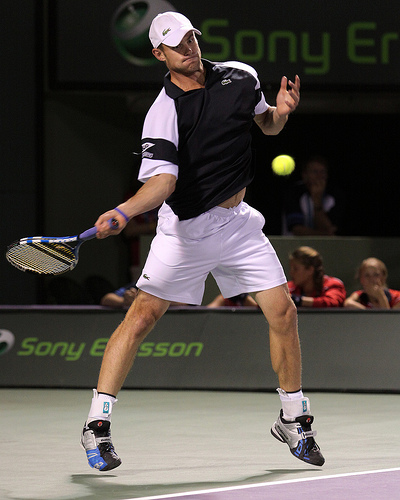

In [ ]:
x = speech_projections @ all_image_embeddings.T
index = x.argmax().item()

IPython.display.Image(os.path.join(IMAGE_PATH, subset500.iloc[index][1]))

In [ ]:
index

22

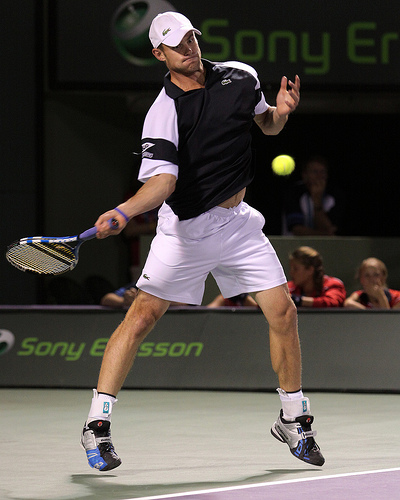

In [ ]:
IPython.display.Image(os.path.join(IMAGE_PATH, subset500.iloc[index][1]))

In [ ]:
list(wav2cap_subset1k_dict.keys())[1629]

IPython.display.Audio('input_audio_file')

'3589367895_5d3729e3ea_3.wav'

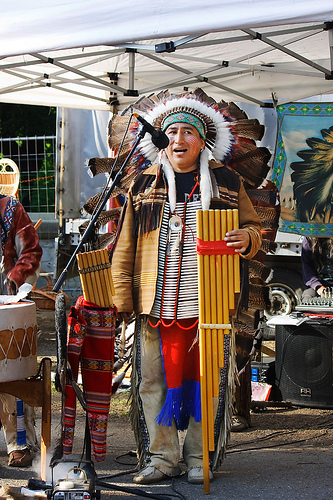

In [ ]:
IPython.display.Image(f"/content/data/images/{wav2cap_subset1k_dict['3589367895_5d3729e3ea_3.wav']}")

In [ ]:
170//16 + 170//16

10

In [ ]:
for i, (image, text) in enumerate(dataloader):
  if i==11: break

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


In [ ]:
image[9]

tensor([[[0.0588, 0.0549, 0.0784,  ..., 0.1216, 0.0784, 0.0784],
         [0.0588, 0.0431, 0.0549,  ..., 0.1373, 0.1176, 0.0863],
         [0.0471, 0.0392, 0.0745,  ..., 0.1216, 0.1412, 0.0980],
         ...,
         [0.3882, 0.3137, 0.2902,  ..., 0.4784, 0.4667, 0.4588],
         [0.3059, 0.3059, 0.2471,  ..., 0.5137, 0.4588, 0.4706],
         [0.5098, 0.5294, 0.5529,  ..., 0.5961, 0.5451, 0.5412]],

        [[0.0980, 0.0745, 0.0980,  ..., 0.1333, 0.0824, 0.0863],
         [0.0824, 0.0627, 0.0745,  ..., 0.1490, 0.1294, 0.0980],
         [0.0627, 0.0588, 0.0902,  ..., 0.1294, 0.1490, 0.1059],
         ...,
         [0.3765, 0.3059, 0.2980,  ..., 0.4549, 0.4431, 0.4471],
         [0.2863, 0.2863, 0.2431,  ..., 0.4863, 0.4392, 0.4588],
         [0.5137, 0.5294, 0.5725,  ..., 0.5647, 0.5020, 0.5059]],

        [[0.0667, 0.0667, 0.1020,  ..., 0.0863, 0.0549, 0.0549],
         [0.0588, 0.0510, 0.0706,  ..., 0.0980, 0.0980, 0.0667],
         [0.0549, 0.0549, 0.0980,  ..., 0.0824, 0.1137, 0.

In [ ]:
image[9].permute(1, 2, 0).shape

torch.Size([224, 224, 3])

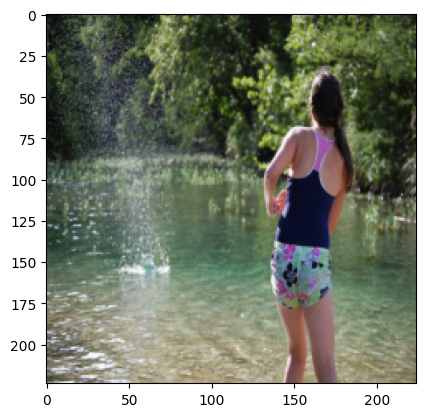

In [ ]:
import matplotlib.pyplot as plt

plt.imshow(image[9].permute(1, 2, 0).cpu())

In [ ]:
import IPython
IPython.display.Audio(input_audio_file)

In [ ]:
dataset = ImageTextDataset(wav2cap_dict, processor)
dataloader = DataLoader(dataset,
                        batch_size=batch_size,
                        shuffle=False,
                        collate_fn=collate_batch,
                        num_workers=num_processors,
                        pin_memory=True)

In [ ]:
IPython.display.Image(input_audio_file)

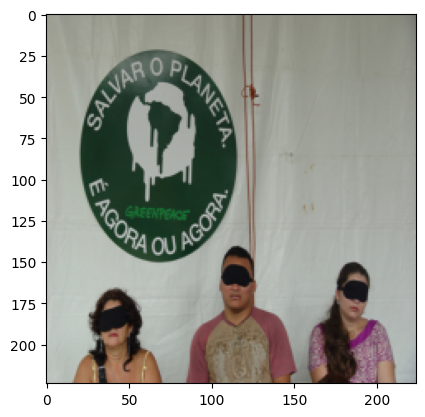

In [ ]:
for _, (i, s) in enumerate(dataloader):
  plt.imshow(i[0].permute(1, 2, 0))
  break

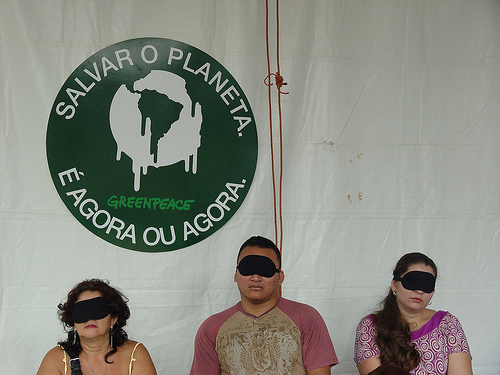

In [ ]:
IPython.display.Image('/content/data/images/3222749441_3bdfe088e3.jpg')

In [ ]:
wav